In [2]:
from astropy.io import fits
from astropy.wcs import WCS
import numpy as np
import matplotlib.pyplot as plt
import os, sys
import pandas as pd

In [3]:
zdata = pd.read_csv('../data/cosmos_3dhst_v4.1.5_catalogs/cosmos_3dhst.v4.1.5.zbest.dat', sep='\t', comment='#')
sfrdata = pd.read_csv('../data/cosmos_3dhst_v4.1.5_catalogs/cosmos_3dhst.v4.1.5.zbest.sfr', sep='\s+', comment='#')
radecdata = pd.read_csv('../data/cosmos_3dhst.v4.1.cats/Catalog/cosmos_3dhst.v4.1.cat', sep='\s+', comment='#')

mask = (zdata['z_best'] > 0) & (sfrdata['sfr_IR'] > 0)
# mask = np.ones(len(zdata['z_best']), dtype=bool)
data = {'ra': radecdata['ra'][mask], 'dec': radecdata['dec'][mask], 'z': zdata['z_best'][mask], 'sfr_IR': sfrdata['sfr_IR'][mask]}

print(len(data['ra']))

18202


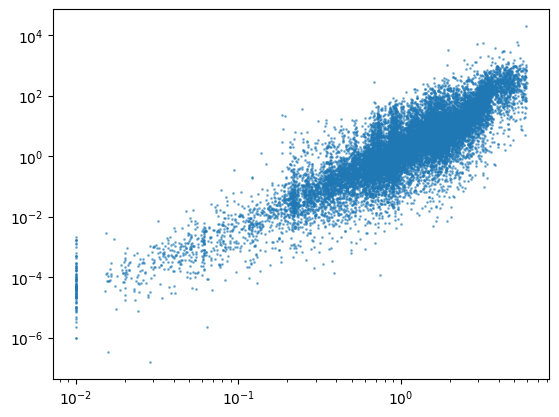

In [4]:
plt.figure()
plt.scatter(data['z'], data['sfr_IR'], s=1, alpha=0.5)
plt.yscale('log')
plt.xscale('log')
# plt.ylim(1e-3, 1e3)
plt.show()
plt.close()

In [5]:
m, b, sigma = 1.01, -6.99, .42
Lcii = np.power(10, (np.log10(data['sfr_IR'])-b) / m)

data['Lcii'] = Lcii

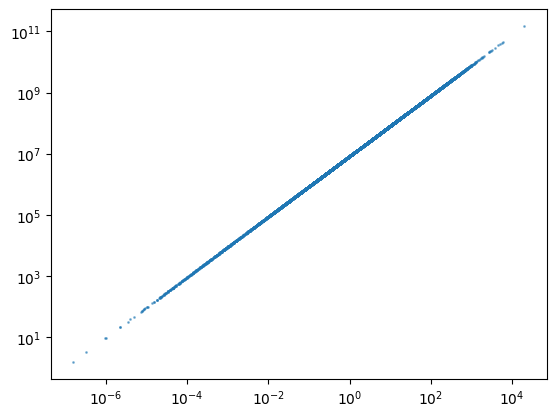

In [6]:
plt.figure()
plt.scatter(data['sfr_IR'], data['Lcii'], s=1, alpha=0.5)
plt.yscale('log')
plt.xscale('log')
# plt.ylim(1e-3, 1e3)
plt.show()
plt.close()

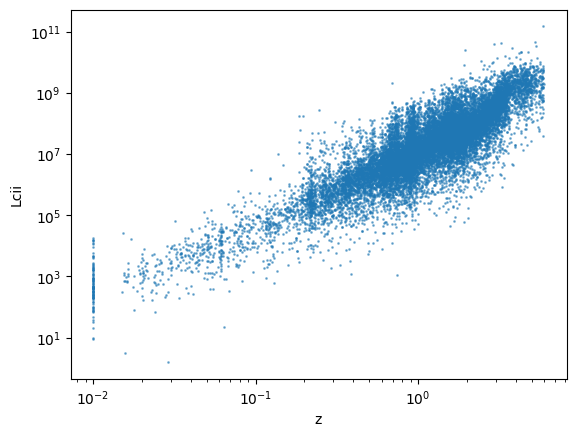

In [7]:
plt.figure()
plt.scatter(data['z'], data['Lcii'], s=1, alpha=0.5)
plt.xlabel('z')
plt.ylabel('Lcii')
plt.yscale('log')
plt.xscale('log')
# plt.ylim(1e-3, 1e3)
plt.show()
plt.close()

In [8]:
# why are there points that have z exactly 0.01? remove them
mask = data['z'] == 0.01
print(np.sum(mask))

data['ra'] = data['ra'][~mask]
data['dec'] = data['dec'][~mask]
data['z'] = data['z'][~mask]
data['sfr_IR'] = data['sfr_IR'][~mask]
data['Lcii'] = data['Lcii'][~mask]

96


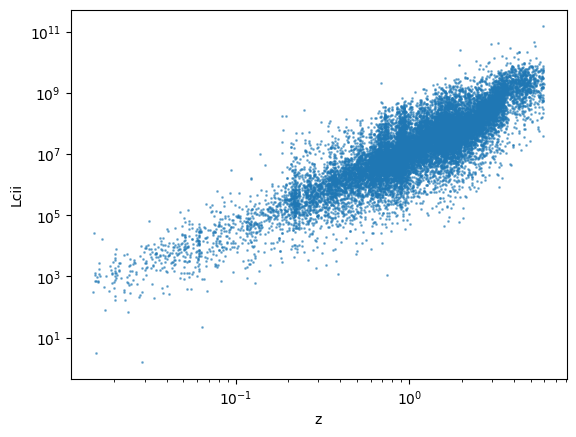

In [9]:
plt.figure()
plt.scatter(data['z'], data['Lcii'], s=1, alpha=0.5)
plt.xlabel('z')
plt.ylabel('Lcii')
plt.yscale('log')
plt.xscale('log')
# plt.ylim(1e-3, 1e3)
plt.show()
plt.close()

In [10]:
print(np.nanmin(data['z']), np.nanmax(data['z']))

0.0151 5.9609


In [29]:
# bin the data by z and calculate the total Lcii in each bin
nbins = 25
zbin_edges = [-np.inf] + list(np.percentile(data['z'], np.linspace(100/nbins, 100, nbins)))[:-1] + [np.inf]
print(zbin_edges, len(zbin_edges))

for i in range(nbins):
    mask = (data['z'] >= zbin_edges[i]) & (data['z'] < zbin_edges[i+1])
    print(np.sum(mask))

[-inf, 0.19424000000000002, 0.2996, 0.41552, 0.52252, 0.6282, 0.6945, 0.755, 0.83962, 0.8936, 0.945, 1.04542, 1.16634, 1.28272, 1.4129800000000001, 1.5181, 1.6120200000000002, 1.7047400000000001, 1.84558, 1.9894, 2.2077, 2.4878199999999997, 2.7882599999999993, 3.156640000000001, 3.7742799999999983, inf] 26
725
723
725
724
721
727
723
726
719
728
726
724
724
724
721
728
724
724
723
725
725
724
724
724
725


In [30]:
data['Lcii'][mask]

50       4.427291e+08
81       3.746132e+09
93       8.364900e+08
112      2.574034e+09
160      2.217041e+09
             ...     
33731    1.061699e+09
33824    2.006198e+09
33861    1.205756e+09
33869    1.985188e+09
33872    8.909951e+09
Name: sfr_IR, Length: 725, dtype: float64

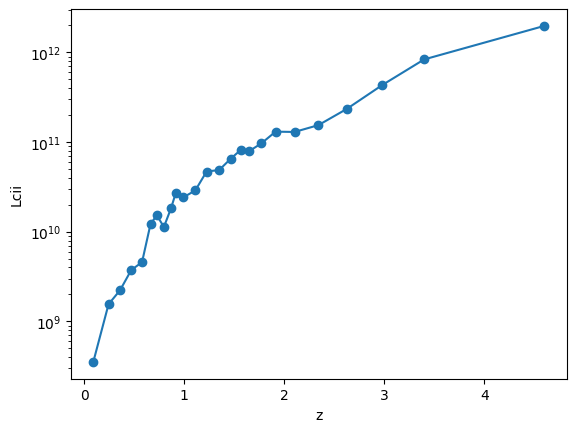

In [56]:
binned_data = {'z': [], 'Lcii': [], 'n': [],
            'zbin_edges': zbin_edges, 'nbins': nbins}

# num_gal = 72

for i in range(len(zbin_edges)-1):
    mask = (data['z'] >= zbin_edges[i]) & (data['z'] < zbin_edges[i+1])
    binned_data['z'].append(np.mean(data['z'][mask]))
    binned_data['Lcii'].append(np.sum(data['Lcii'][mask]))
    # Lciis = np.array(data['Lcii'][mask])
    # binned_data['Lcii'].append(np.sum(Lciis[np.argpartition(Lciis, -num_gal)[-num_gal:]]))
    binned_data['n'].append(np.sum(mask))

plt.figure()
plt.plot(binned_data['z'], binned_data['Lcii'], 'o-')
plt.xlabel('z')
plt.ylabel('Lcii')
plt.yscale('log')
# plt.xscale('log')
# plt.ylim(1e-3, 1e3)
plt.show()
plt.close()

In [57]:
binned_data['n']

[725,
 723,
 725,
 724,
 721,
 727,
 723,
 726,
 719,
 728,
 726,
 724,
 724,
 724,
 721,
 728,
 724,
 724,
 723,
 725,
 725,
 724,
 724,
 724,
 725]

In [58]:
ra_range = np.nanmax(data['ra']) - np.nanmin(data['ra'])
dec_range = np.nanmax(data['dec']) - np.nanmin(data['dec'])
print(ra_range, dec_range)

dOmega = np.deg2rad(ra_range) * np.deg2rad(dec_range) * np.cos(np.deg2rad(np.mean(data['dec'])))
print(dOmega)

0.15740967000002115 0.39081215999999985
1.8723487871810384e-05


In [59]:
from astropy import units as u, constants as c
from astropy.cosmology import Planck18 as cosmo

CII_freq = 1900e9 # Hz
CII_wav = c.c.to(u.m/u.s).value / CII_freq
dLs = cosmo.luminosity_distance(binned_data['z']).to(u.m).value
Lciis = np.array(binned_data['Lcii']) * c.L_sun.to(u.W).value

zbin_edges = np.array(binned_data['zbin_edges'])
zbin_edges[0] = 0
zbin_edges[-1] = 6

drs = cosmo.luminosity_distance(zbin_edges).to(u.m).value[1:] - cosmo.luminosity_distance(zbin_edges).to(u.m).value[:-1]
dfs = drs * cosmo.H(binned_data['z']).to(u.s**-1).value / (1 + np.array(binned_data['z']))**2 / CII_wav

Lcii_density = Lciis / dOmega / dfs / (4 * np.pi * dLs**2) * 1e26 # Jy / sr

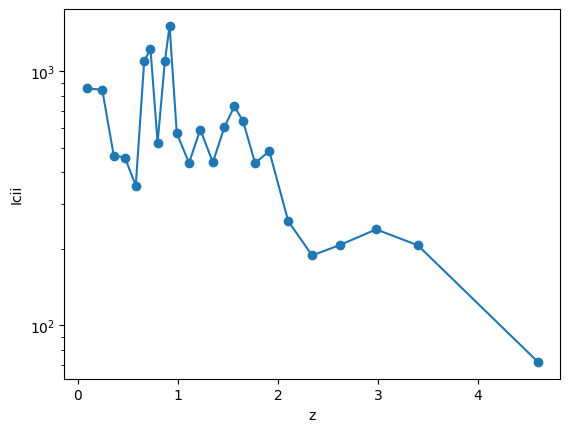

In [60]:
plt.figure()
plt.plot(binned_data['z'], Lcii_density, 'o-')
plt.xlabel('z')
plt.ylabel('Icii')
plt.yscale('log')
# plt.xscale('log')
# plt.ylim(1e-3, 1e3)
plt.show()
plt.close()

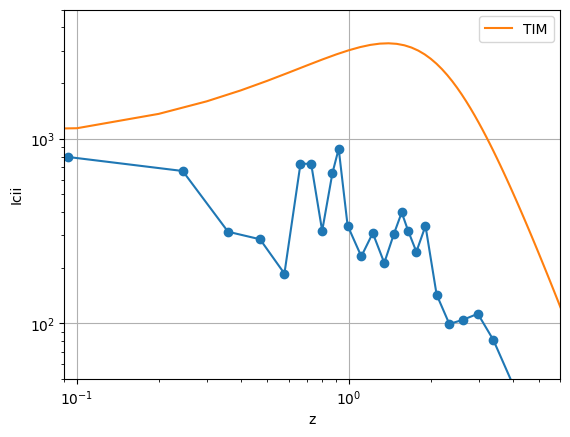

In [55]:
timmodel = np.load('../data/ryan/justincii_model.npy')

plt.figure()
plt.plot(binned_data['z'], Lcii_density, 'o-')
plt.plot(timmodel[0], timmodel[1], label='TIM')
plt.xlabel('z')
plt.ylabel('Icii')
plt.yscale('log')
plt.xscale('log')
plt.ylim(5e1, 5e3)
plt.grid()
plt.legend()
plt.xlim(0.09, 6)
plt.show()
plt.close()

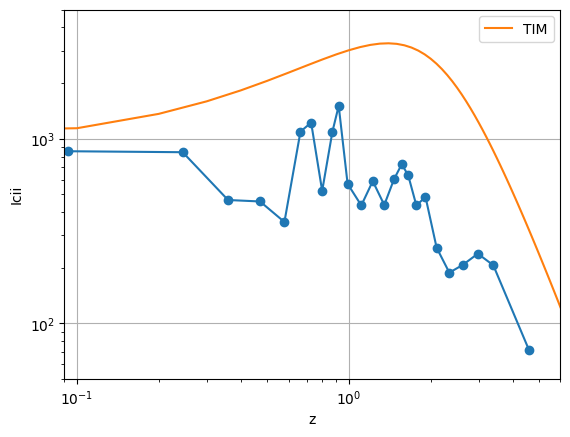

In [61]:
timmodel = np.load('../data/ryan/justincii_model.npy')

plt.figure()
plt.plot(binned_data['z'], Lcii_density, 'o-')
plt.plot(timmodel[0], timmodel[1], label='TIM')
plt.xlabel('z')
plt.ylabel('Icii')
plt.yscale('log')
plt.xscale('log')
plt.ylim(5e1, 5e3)
plt.grid()
plt.legend()
plt.xlim(0.09, 6)
plt.show()
plt.close()